In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.integrate import solve_ivp

plt.style.use(["seaborn-v0_8-colorblind","seaborn-v0_8-paper"]) # "seaborn-v0_8-colorblind"
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.shadow"] = True
plt.rcParams["legend.framealpha"] = 0.6
color_map = "plasma"

from GFDM import create_system_K_F

In [3]:
# Mesh
nx = 40
ny = 20

x = np.linspace(0,2,nx)
y = np.linspace(0,1,ny)
x,y = np.meshgrid(x,y)

In [4]:
p = np.vstack((x.flatten(), y.flatten())).T
p[:10,:]

array([[0.        , 0.        ],
       [0.05128205, 0.        ],
       [0.1025641 , 0.        ],
       [0.15384615, 0.        ],
       [0.20512821, 0.        ],
       [0.25641026, 0.        ],
       [0.30769231, 0.        ],
       [0.35897436, 0.        ],
       [0.41025641, 0.        ],
       [0.46153846, 0.        ]])

(-0.1, 2.1, -0.05, 1.05)

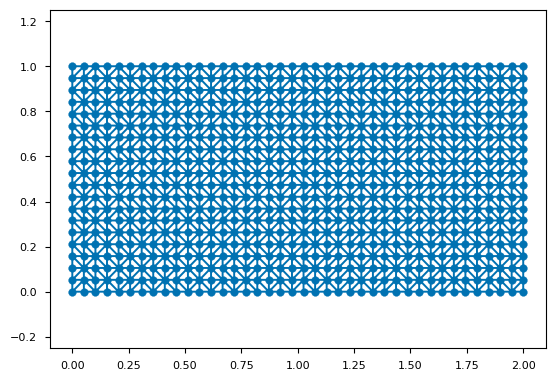

In [5]:
tri = Delaunay(p)
plt.triplot(p[:,0], p[:,1], tri.simplices)
plt.scatter(x,y)
# for i in range(p.shape[0]):
#     plt.text(p[i,0],p[i,1],s=str(i))
plt.axis("equal")

(-0.1, 2.1, -0.05, 1.05)

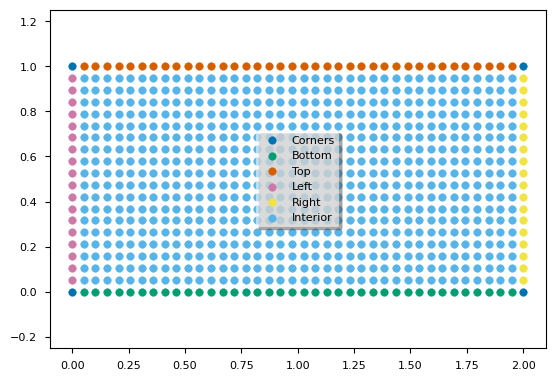

In [6]:
# Boundaries index
bc = np.array([1, nx,  nx*ny-nx+1, nx*ny]) - 1      # corners
bcb = bc[:2]                                        # cornesrs bottom
bct = bc[2:]                                        # corners top
bcl = np.array([bc[0],bc[2]])                       # corners left
bcr = np.array([bc[1],bc[3]])                       # corners right
bb = np.arange(1, nx-1)                             # bottom
bt = np.arange(nx*ny-nx+1, nx*ny-1)                 # top
bl = np.arange(nx, nx*ny-nx, nx)                    # left
br = np.arange(2*nx-1, nx*ny-nx, nx)                # right
Boundaries = np.hstack((bc,bb,bt,bl,br))

# interior index
interior = np.arange(0,nx*ny)
interior = np.setdiff1d(interior, Boundaries)

plt.scatter(p[bc,0], p[bc,1], label="Corners")
plt.scatter(p[bb,0], p[bb,1], label="Bottom")
plt.scatter(p[bt,0], p[bt,1], label="Top")
plt.scatter(p[bl,0], p[bl,1], label="Left")
plt.scatter(p[br,0], p[br,1], label="Right")
plt.scatter(p[interior,0], p[interior,1], label="Interior")
plt.legend(loc="center")
plt.axis("equal")

In [7]:
# Problem parameters
a = 0.2637
b = 0.1
k = lambda p: 1         # difusividad
f = lambda p: 0         # fuente

In [8]:
L2 = np.array([0,0,0,2,0,2])

In [9]:
# Boundary conditions $\Psi$
Psit = lambda p: 1
Psib = lambda p: 0
Psil = lambda p: 0
Psir = lambda p: 0

materiales = {}
materiales["0"] = [k, interior]

fronteas_dirichlet = {}
fronteas_dirichlet["top"] = [bt, Psit]
fronteas_dirichlet["bottom"] = [bb, Psib]
fronteas_dirichlet["esquinas_top"] = [bct, Psit]
fronteas_dirichlet["esquinas_bottom"] = [bcb, Psib]

fronteras_neumann = {}
fronteras_neumann["left"] = [k, bl, Psil]
fronteras_neumann["right"] = [k, br, Psir]

In [10]:
# $D$ matrix for $\Psi$
D2psi, F2psi = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=L2,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
D2psi = D2psi.toarray()
F2psi = F2psi.toarray()[:,0]

Lx = np.array([0,1,0,0,0,0])
Dxpsi, Fxpsi = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=Lx,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
Dxpsi = Dxpsi.toarray()
Fxpsi = Fxpsi.toarray()[:,0]

Ly = np.array([0,0,1,0,0,0])
Dypsi, Fypsi = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=Ly,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
Dypsi = Dypsi.toarray()
Fypsi = Fypsi.toarray()[:,0]

In [11]:
# Boundary conditions $C$
Cl = lambda p: 0
Cr = lambda p: 1
Ct = lambda p: 0
Cb = lambda p: 0


fronteas_dirichlet = {}
fronteas_dirichlet["left"] = [bl, Cl]
fronteas_dirichlet["right"] = [br, Cr]
fronteas_dirichlet["esquinas_left"] = [bcl, Cl]
fronteas_dirichlet["esquinas_right"] = [bcr, Cr]

fronteras_neumann = {}
fronteras_neumann["top"] = [k, bt, Ct]
fronteras_neumann["bottom"] = [k, bb, Cb]

In [12]:
# D matrix for $C$
D2c, F2c = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=L2,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
D2c = D2c.toarray()
F2c = F2c.toarray()[:,0]

Dxc, Fxc = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=Lx,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
Dxc = Dxc.toarray()
Fxc = Fxc.toarray()[:,0]

Dyc, Fyc = create_system_K_F(
    p=p,
    triangles=tri.simplices,
    L=Ly,
    source=f,
    materials=materiales,
    dirichlet_boundaries=fronteas_dirichlet,
    neumann_boundaries=fronteras_neumann
)
Dyc = Dyc.toarray()
Fyc = Fyc.toarray()[:,0]

In [13]:
"""
Ensamble del IVP
"""
#  modificaciones para no afectar las condiciones de frontera
Dxcpsi = Dxc.copy()
Dxcpsi[:,Boundaries] = 0
Dxcpsi[Boundaries,:] = 0
Fxcpsi = Fxc.copy()
Fxcpsi[Boundaries] = 0

Dypsic = Dypsi.copy()
Dypsic[:,Boundaries] = 0
Dypsic[Boundaries,:] = 0
Dypsic[Boundaries,Boundaries] = 1
Fypsic = Fypsi.copy()
Fypsic[Boundaries] = 0

Dxpsic = Dxpsi.copy()
Dxpsic[:,Boundaries] = 0
Dxpsic[Boundaries,:] = 0
Dxpsic[Boundaries,Boundaries] = 1
Fxpsic = Fxpsi.copy()
Fxpsic[Boundaries] = 0

In [14]:
# Parte lineal del sistema (matriz A)
N = p.shape[0]
A = np.vstack((
    np.hstack((
        D2psi, -1/a * Dxcpsi
    )),
    np.hstack((
        np.zeros((N,N)), D2c
    ))
))

# Valores conocidos lineales (vector Fl)
Fl = np.hstack((
    - F2psi  +  1/a * Fxcpsi,
    - F2c
))

# Parte no lineal (Vector B)
def B(U):
    term1 = (Dypsic@U[:N]) * (Dxc@U[N:])
    term2 = (Dxpsic@U[:N]) * (Dyc@U[N:])
    vec2 = -1/b * (term1 - term2) 
    vec1 = np.zeros(N)
    vec = np.hstack((vec1, vec2))
    return vec

# Valores conocidos no lineales (vector Fn)
Fn = np.hstack((
    np.zeros(N),
    - 1/b * (Fypsic*Fxc - Fxpsic*Fyc)
))

# Acoplamiento del lado derecho en la función anónima fun

fun = lambda t,U: A@U + Fl + B(U) + Fn

<>:31: SyntaxWarning: invalid escape sequence '\P'
<>:31: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_30689/1563211374.py:31: SyntaxWarning: invalid escape sequence '\P'
  ax.set_title("$\Psi_0$")


Text(0.5, 0.92, '$C_0$')

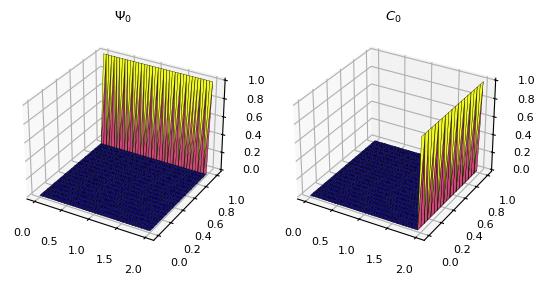

In [15]:
# Condiciones iniciales
C0 = np.zeros(N)
Psi0 = np.zeros(N)
for i in bl:
    C0[i] = Cl(p[i,:])
    Psi0[i] = Psil(p[i,:])
for i in br:
    C0[i] = Cr(p[i,:])
    Psi0[i] = Psir(p[i,:])
for i in bt:
    C0[i] = Ct(p[i,:])
    Psi0[i] = Psit(p[i,:])
for i in bb:
    C0[i] = Cb(p[i,:])
    Psi0[i] = Psib(p[i,:])

for i in bcl:
    C0[i] = Cl(p[i,:])
for i in bcr:
    C0[i] = Cr(p[i,:])
for i in bct:
    Psi0[i] = Psit(p[i,:])
for i in bcb:
    Psi0[i] = Psib(p[i,:])

U0 = np.hstack((Psi0, C0))

fig = plt.figure()
ax = plt.subplot(1, 2, 1, projection="3d")
ax.plot_trisurf(p[:,0],p[:,1],Psi0, cmap=color_map, edgecolor="k")
ax.set_title("$\Psi_0$")
ax2 = plt.subplot(1, 2, 2, projection="3d")
ax2.plot_trisurf(p[:,0],p[:,1],C0, cmap=color_map, edgecolor="k")
ax2.set_title("$C_0$")

In [16]:
# Solución del IVP
tspan = [0,1.6]             # intervalo de solución
sol = solve_ivp(fun, tspan, U0, method="RK45")

U = sol.y

<>:28: SyntaxWarning: invalid escape sequence '\P'
<>:28: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_30689/2842203244.py:28: SyntaxWarning: invalid escape sequence '\P'
  fig.suptitle("$\Psi$")


Text(0.5, 0.98, '$C$')

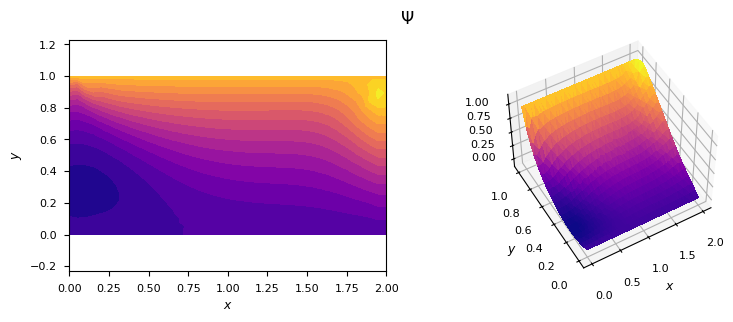

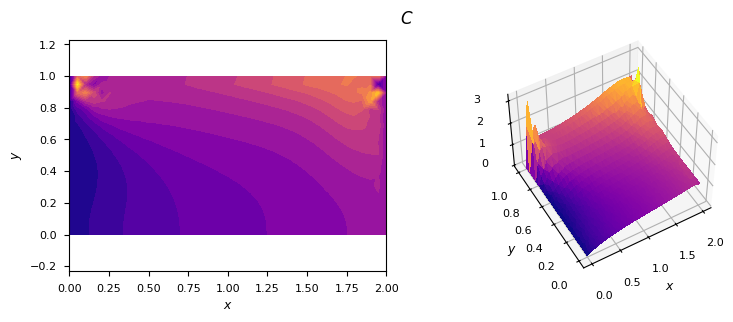

In [17]:
# Gráfica de la solución en el tiempo final
fig = plt.figure(figsize=(9,3))
ax2 = plt.subplot(1,2,2, projection="3d")
ax2.plot_trisurf(
    p[:,0],
    p[:,1],
    U[:N,-1],
    cmap=color_map,
    linewidth=1,
    antialiased=False
)
ax2.view_init(azim=-120, elev=50)
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")

ax1 = plt.subplot(1,2,1)
ax1.tricontourf(
    p[:,0],
    p[:,1],
    U[:N,-1],
    levels=20,
    cmap=color_map
)
ax1.axis("equal")
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

fig.suptitle("$\Psi$")

fig = plt.figure(figsize=(9,3))
ax3 = plt.subplot(1,2,1)
ax3.tricontourf(
    p[:,0],
    p[:,1],
    U[N:,-1],
    levels=20,
    cmap=color_map
)
ax3.axis("equal")
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')

ax4 = plt.subplot(1,2,2, projection="3d")
ax4.plot_trisurf(
    p[:,0],
    p[:,1],
    U[N:,-1],
    cmap=color_map,
    linewidth=1,
    antialiased=False
)
ax4.view_init(azim=-120, elev=50)
ax4.set_xlabel("$x$")
ax4.set_ylabel("$y$")
fig.suptitle("$C$")